# Welcome! This notebook will guide you through using our OMR system. 
### Before you begin:
- Clone the repo https://github.com/dmgonzalez8/OMR/
- Download the dense dataset https://zenodo.org/records/4012193 and extract to `./data`
- Download the latest models https://drive.google.com/drive/folders/13Z64ReEJGlMnCqPkA-dcCD8tzdtvLyqO?usp=sharing and extract to the local folder

## First we will start with our FasterRCNN model

These three imports will take care of all of the training setup

In [8]:
from faster_rcnn_torch.preprocess_data import *
from faster_rcnn_torch.image_preprocessing import *
from faster_rcnn_torch.train_model import *

Assuming you have done the above, the first step is to preprocess the data using the following function which can also be run via the command line. It does the following: 
- Import the JSON data dictionaries which contain the bounding boxes
- Import the list of unique classes for symbols from a CSV
- Remap raw labels to match the list of unique labels (the provided raw labels have duplicates)
- Impute values for variables which have missing data
- Create a df of all images with their bounding boxes and other features
- Add the additional features such as barlines into this df
- Resizes all over/under sized images
- Add random distortion to all images and saves them in the `./data/ds2_dense/processed_images` folder
- Recompute bounding boxes for resized images
- Save the df to a pickle and CSV file in the local directory

In [9]:
json_dir = './data/ds2_dense/' # path of deepscores_train.json
labels_path = './faster_rcnn_torch/new_labels.csv' # path of unique labels CSV
n_jobs = 4 # parallel processing 
preprocess_data(json_dir, labels_path, n_jobs)

Reading 2 of 2: deepscores_test.json ...
Reading 1 of 2: deepscores_train.json ...
Read JSON complete.
Make unique label list complete.
Extracted tables from JSON.
Updated labels to new mapping.
Updated durations and relative positions.
Read JSON complete.
Make unique label list complete.
Cleaned up tables.
Merged bboxs and images together.
Processed barlines into main df.
Aggregated dfs down to single row per image.
Extracted tables from JSON.
Updated labels to new mapping.
Updated durations and relative positions.
Cleaned up tables.
Merged bboxs and images together.
Processed barlines into main df.
Aggregated dfs down to single row per image.
Image resize and distortion complete.
Added padding where needed.
Computed areas.
Processed deepscores_test.json, saved csv and pickle files.
Image resize and distortion complete.
Added padding where needed.
Computed areas.
Processed deepscores_train.json, saved csv and pickle files.


### Now we can train the model using the following command and parameters:
- json_directory: directory with deepscores_train.json
- optimizer: SGD, Adam, Adadelta, AdamW, RMSprop
- batch_size: batch size
- num_epochs: number of epochs to train for
- checkpoint: optional path to a pretrained .pt file
  
This takes a long time. The model will save a .pt file every 100 epochs.

In [12]:
! python3 ./faster_rcnn_torch/train_model.py './data/ds2_dense/' 'SGD' 2 100 --checkpoint './OMR_FasterRCNN_SGD_3000.pt'

Loaded checkpoint model from: ./OMR_FasterRCNN_SGD_3000.pt
Starting epoch 1.
^C


### Testing the model
To test the model, give the path to the model.pt file and an image to classify.

In [20]:
image_path = './data/ds2_dense/images/lg-10247684-aug-gonville--page-3.png'
model_pt_path = './OMR_FasterRCNN_SGD_3000.pt'

In [21]:
# Load JSON data into a dictionary
with open('./data/ds2_dense/deepscores_train.json') as file:
    data1 = json.load(file)
with open('./data/ds2_dense/deepscores_test.json') as file:
    data2 = json.load(file)

In [22]:
# convert to pandas
# train_labels = pd.DataFrame( data1['categories']).T
train_images = pd.DataFrame( data1['images'])
train_obboxs = pd.DataFrame( data1['annotations']).T
# test_labels = pd.DataFrame( data2['categories']).T
test_images = pd.DataFrame( data2['images'])
test_obboxs = pd.DataFrame( data2['annotations']).T

In [23]:
unique_labels = pd.read_pickle('./data/ds2_dense/unique_labels.pkl')
num_classes = len(unique_labels) + 1  # Define the number of classes including background

In [24]:
def get_model(num_classes):
    # Load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(num_features, num_classes)
    
    return model

In [25]:
# Load the trained model's state dictionary
state_dict = torch.load(model_pt_path, map_location=torch.device('cpu'))
# Adjust the keys to remove 'module.' prefix added by DataParallel
new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
# Assuming get_model is your function to initialize the model
model = get_model(num_classes)
# Load the adjusted state dictionary into the model
model.load_state_dict(new_state_dict)
# Set the model to evaluation mode
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

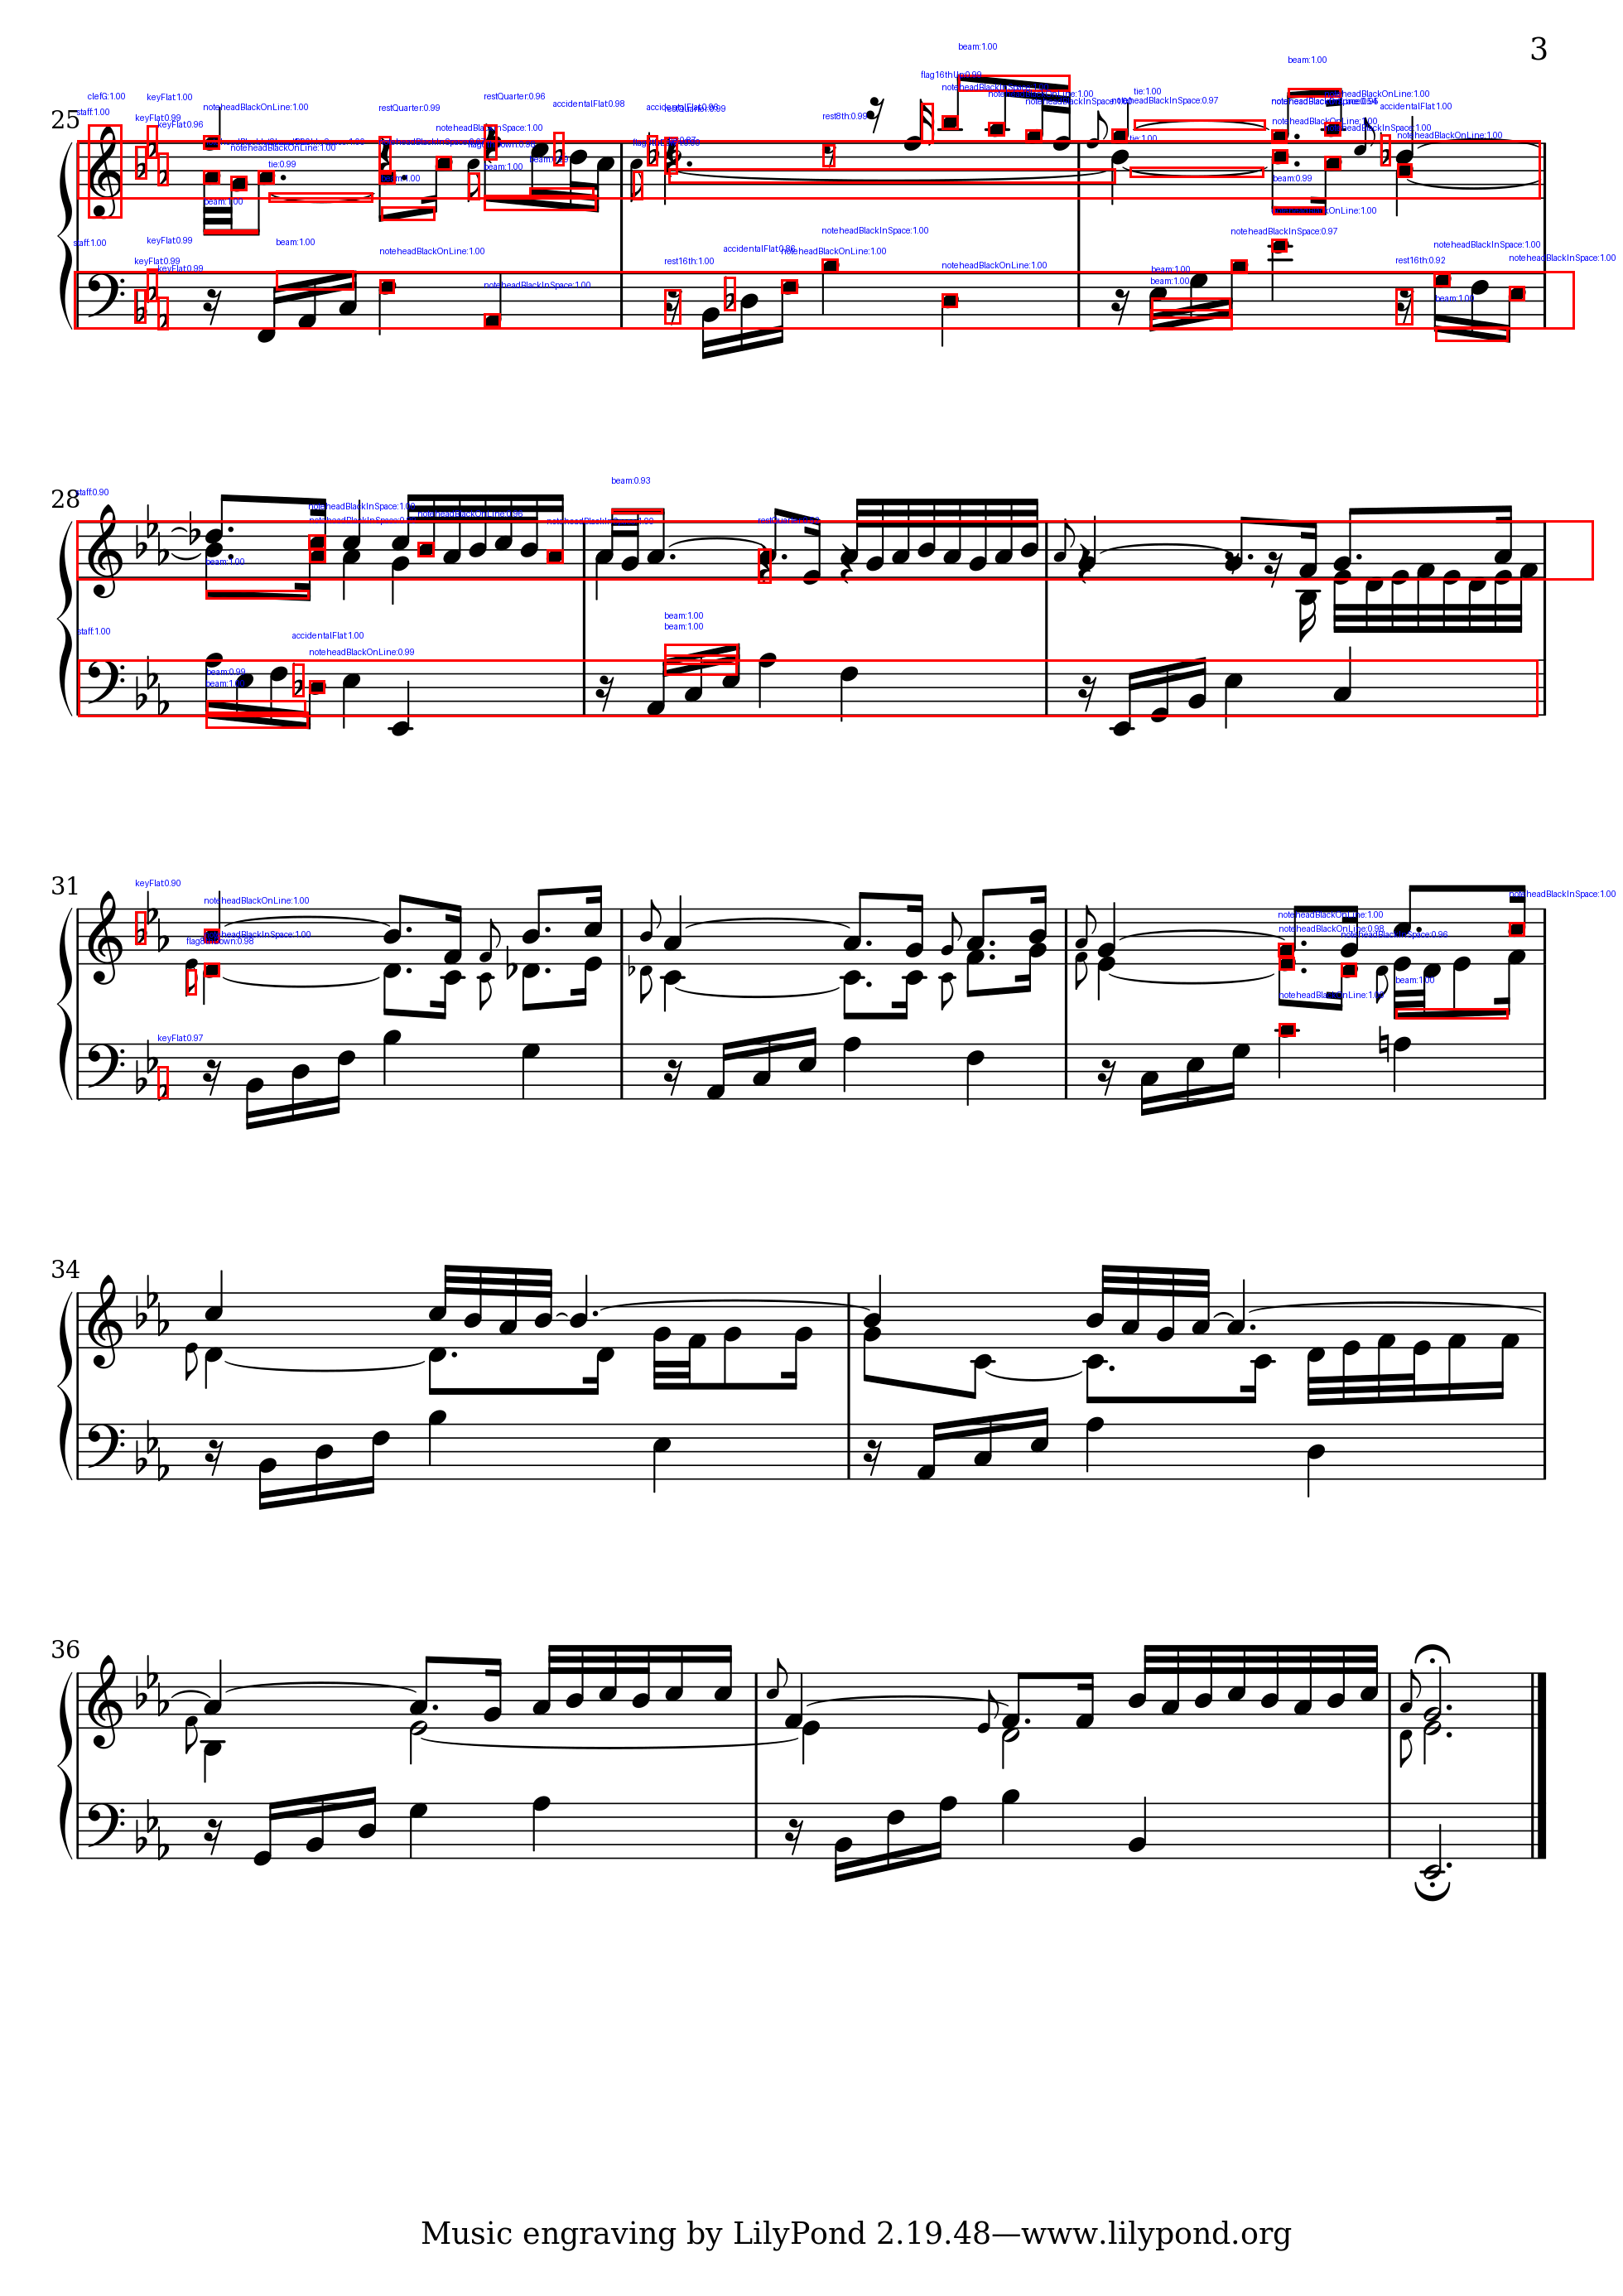

In [26]:
# Load the image
image = Image.open(image_path).convert("L")
image_tensor = F.to_tensor(image).unsqueeze(0)  # Convert image to tensor

# Convert DataFrame to a dictionary
label_dict = dict(zip(unique_labels['label'], unique_labels['name']))

# Perform prediction
with torch.no_grad():
    predictions = model(image_tensor)

image = Image.open(image_path).convert("RGB")
# Draw predictions on the image
draw = ImageDraw.Draw(image)
# Specify a larger font size for the annotations
font = ImageFont.load_default()  # Currently, load_default does not support size adjustment in PIL

for element in range(len(predictions[0]['boxes'])):
    boxes = predictions[0]['boxes'][element].cpu().numpy().astype(int)
    label_id = predictions[0]['labels'][element].item()
    score = predictions[0]['scores'][element].item()

    # Look up the label name using the label dictionary
    label_name = label_dict.get(label_id, 'Unknown')  # Default to 'Unknown' if not found

    if score > 0.5:  # filter out low-confidence predictions
        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], outline='red', width=3)
        draw.text((boxes[0], boxes[1]-40), f'{label_name}:{score:.2f}', fill='blue', font=font)  
# Save or show image
image.show()
image

# YOLO Model

In [11]:
import pandas as pd
import numpy as np

from ultralytics import YOLO
import shutil
import yaml
import ast
import torch
import json
import os
import re

from shapely.geometry import Polygon, LineString, Point
from PIL import Image, ImageDraw, ImageFont, ImageFilter


# Load the Data

In [12]:
# Load JSON data into a dictionary
with open('./ds2_dense/deepscores_train.json') as file:
    data1 = json.load(file)
with open('./ds2_dense/deepscores_test.json') as file:
    data2 = json.load(file)

In [13]:
train_images = pd.DataFrame( data1['images'])
train_obboxs = pd.DataFrame( data1['annotations']).T

test_images = pd.DataFrame( data2['images'])
test_obboxs = pd.DataFrame( data2['annotations']).T

# Splitting the Images into Train and Test sets

Note this step probably isn't necessary if you used the entire images directory for training; this part just splits it up into training and testing based on the files specified in the train and test jsons.

In [14]:
train_dir = './ds2_dense/images/train'
test_dir = './ds2_dense/images/test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [15]:
# Move train images to train directory
#for image_filename in train_images['filename']:
#    src_path = os.path.join(image_dir, image_filename)
#    dest_path = os.path.join(train_dir, image_filename)
#    shutil.move(src_path, dest_path)

In [16]:
#for image_filename in test_images['filename']:
#    src_path = os.path.join(image_dir, image_filename)
#    dest_path = os.path.join(test_dir, image_filename)
#    shutil.move(src_path, dest_path)

# Labels

<span style="background-color:rgb(255,255,150)">The yolo model wants labels to be zero-based indexing, so I subtracted 1</span>


In [17]:
raw_labels = pd.read_csv('new_labels.csv')
raw_labels['label'] -= 1
raw_labels.head()

,old_index,old_id,name,dataset,color,label
0,0,1,brace,deepscores,1,0
1,1,137,brace,muscima++,1,0
2,2,2,ledgerLine,deepscores,2,1
3,3,138,ledgerLine,muscima++,2,1
4,4,3,repeatDot,deepscores,7,2


In [18]:
unique_labels = raw_labels[['label', 'name']]
unique_labels = unique_labels.drop_duplicates(subset=['label'])
unique_labels = unique_labels.sort_values(by=['label']).reset_index(drop=True)

# Yaml file for Training 

With `Yolo`, a yaml file is specified for training. Below are common key-value pairs in these dataset yaml files: 

- **path**: Specifies the root directory of the dataset.
- **train**: Specifies the path to the directory containing training images. This path is usually relative to the dataset root directory - -- -specified in the 'path' key.
- **val**: Specifies the path to the directory containing validation images. Similar to 'train', this path is relative to the dataset root directory.
- **test**: Specifies the path to the directory containing test images, if applicable. This path is also relative to the dataset root directory.
- **names**: Contains label-name mappings for the classes in the dataset. It typically consists of a dictionary where the keys are class IDs (usually integers) and the values are the corresponding class names (strings).
- **download**: Optional key that may specify a URL or script for downloading the dataset.

Based on what is online, it seems people ran into issues using relative paths, so it is probably best to always use absolute paths when specifyng the path to the `path` key 

In [19]:
# Get the absolute path of where this is running
notebook_dir = os.getcwd()

# Append the directory 'ds2_dense/data' for the data path
data_path = os.path.join(notebook_dir, 'ds2_dense')

print("Data directory:", data_path)

Data directory: /Users/erenbardak/DeepLearning/OMR/ds2_dense


In [20]:
def generate_yaml_from_dataframe(df):
    """
    Generate the 'names' section of YAML from a DataFrame containing label and name mappings.

    Input:
        df (DataFrame): DataFrame containing 'label' and 'name' columns.

    Output:
        str: YAML-formatted text for the 'names' section.
    """
    yaml_text = "names:\n"
    
    for index, row in df.iterrows():
        yaml_text += f"  {row['label']}: {row['name']}\n"
        
    return yaml_text

In [21]:
def write_yaml_dataset(path, train_path, val_path, label_df=None, filename='deep_scores.yaml'):
    """
    Write dataset paths and label-name mappings to a YAML file.

    Args:
        path (str): Dataset root directory.
        train_path (str): Path to train images directory (relative to the 'path').
        test_path (str): Path to test images directory (relative to 'path').
        label_df (DataFrame): DataFrame containing label and name mappings. 
        filename (str): Name of the YAML file to write.
    """
    # Data
    data = {
        'path': path,
        'train': train_path,
    }

    if val_path is not None:
        data['val'] = val_path

    if label_df is not None:
        label_yaml = generate_yaml_from_dataframe(label_df)
        data['names'] = yaml.load(label_yaml, Loader=yaml.SafeLoader)

    # Convert data to YAML string
    yaml_text = "path: {}\ntrain: {}\n".format(path, train_path)
    if val_path is not None:
        yaml_text += "val: {}\n".format(val_path)

    if label_df is not None:
        yaml_text += label_yaml

    # Write data to YAML file
    with open(filename, 'w') as yaml_file:
        yaml_file.write(yaml_text)


In [22]:
# Specify function arguments 
train_path = 'images/train'
val_path = 'images/test'
label_df = unique_labels

In [23]:
write_yaml_dataset(data_path, 
           train_path, 
           val_path, 
           label_df)

In [24]:
train_images.rename(columns={'id': 'img_id'}, inplace=True)
test_images.rename(columns={'id': 'img_id'}, inplace=True)
test_images.head(3)

,img_id,filename,width,height,ann_ids
0,1,lg-75827152-aug-lilyjazz-.png,1960,2772,"[160131, 160132, 160133, 160134, 160135, 16013..."
1,5,lg-210359136-aug-lilyjazz--page-14.png,1960,2772,"[503778, 503779, 503780, 503781, 503782, 50378..."
2,6,lg-366136986510816260-aug-gutenberg1939-.png,1960,2772,"[769765, 769766, 769767, 769768, 769769, 76977..."


In [25]:
# remap the class labels
class_mapping = dict(zip(raw_labels['old_id'].astype(str), raw_labels['label']))

# Define a function to replace each cat_id list with corresponding class names
def map_cat_ids_to_classes(cat_ids):
    return [class_mapping.get(str(cat_id)) for cat_id in cat_ids]

def clean_labels(label_list):
    # Use a set comprehension to remove duplicates and filter out None values
    return list({label for label in label_list if label is not None})
    
def select_highest_precedence(label_list):
    return max(label_list)

# Apply this function to the cat_id column in train and test obboxs DataFrames
train_obboxs['label'] = train_obboxs['cat_id'].apply(map_cat_ids_to_classes)
test_obboxs['label'] = test_obboxs['cat_id'].apply(map_cat_ids_to_classes)
train_obboxs['label'] = train_obboxs['label'].apply(clean_labels)
test_obboxs['label'] = test_obboxs['label'].apply(clean_labels)
train_obboxs['label'] = train_obboxs['label'].apply(select_highest_precedence)
test_obboxs['label'] = test_obboxs['label'].apply(select_highest_precedence)
train_obboxs.head()

,a_bbox,o_bbox,cat_id,area,img_id,comments,label
1020,"[116.0, 139.0, 2315.0, 206.0]","[2315.0, 206.0, 2315.0, 139.0, 116.0, 139.0, 1...","[135, 208]",18945,679,instance:#000010;,154
1021,"[116.0, 309.0, 2315.0, 376.0]","[2315.0, 376.0, 2315.0, 309.0, 116.0, 309.0, 1...","[135, 208]",19223,679,instance:#000021;,154
1022,"[1880.0, 561.0, 1911.0, 564.0]","[1911.0, 564.0, 1911.0, 561.0, 1880.0, 561.0, ...","[2, 138]",120,679,instance:#000022;,1
1023,"[1883.0, 578.0, 1911.0, 580.0]","[1911.0, 580.0, 1911.0, 578.0, 1883.0, 578.0, ...","[2, 138]",27,679,instance:#000023;,1
1024,"[1827.0, 561.0, 1857.0, 564.0]","[1857.0, 564.0, 1857.0, 561.0, 1827.0, 561.0, ...","[2, 138]",112,679,instance:#000024;,1


In [26]:
# Function to extract duration and relative position from comments
def extract_info(comment):
    duration = re.search(r'duration:(\d+);', comment)
    rel_position = re.search(r'rel_position:(-?\d+);', comment)
    return [int(duration.group(1)) if duration else None, int(rel_position.group(1)) if rel_position else None]
    
# Apply the function to create new columns
train_obboxs[['duration', 'rel_position']] = train_obboxs['comments'].apply(extract_info).tolist()
test_obboxs[['duration', 'rel_position']] = test_obboxs['comments'].apply(extract_info).tolist()
train_obboxs.iloc[100:104]

,a_bbox,o_bbox,cat_id,area,img_id,comments,label,duration,rel_position
1120,"[1295.0, 134.0, 1296.0, 186.0]","[1296.0, 186.0, 1296.0, 134.0, 1295.0, 134.0, ...","[42, 161]",105,679,instance:#000089;,61,NaN,NaN
1121,"[1321.0, 612.0, 1341.0, 629.0]","[1343.3448486328125, 623.862060546875, 1337.48...","[27, 157]",276,679,instance:#00008a;duration:16;rel_position:-13;,44,16.0,-13.0
1122,"[1340.0, 513.0, 1341.0, 617.0]","[1341.0, 617.0, 1341.0, 513.0, 1340.0, 513.0, ...","[42, 161]",201,679,instance:#00008b;,61,NaN,NaN
1123,"[1358.0, 156.0, 1378.0, 172.0]","[1378.0, 156.0, 1358.0, 156.0, 1358.0, 172.0, ...","[27, 157]",279,679,instance:#00008c;duration:8;rel_position:1;,44,8.0,1.0


In [35]:
# create a mask for the duration to mark where the duration is relevent
train_obboxs['duration_mask'] = train_obboxs['duration'].notna().astype(int)
test_obboxs['duration_mask'] = test_obboxs['duration'].notna().astype(int)
# set items with no duration to -1
# we may need to reapproach this with another method
train_obboxs['duration'] = train_obboxs['duration'].replace(np.nan,-1)
test_obboxs['duration'] = test_obboxs['duration'].replace(np.nan,-1)

# create a mask for the rel_position to mark where the rel_position is relevent
train_obboxs['rel_position_mask'] = train_obboxs['rel_position'].notna().astype(int)
test_obboxs['rel_position_mask'] = test_obboxs['rel_position'].notna().astype(int)
# set items with no rel_position to 50 (nothing has a position this high)
# we may need to reapproach this with a KNN inference
train_obboxs['rel_position'] = train_obboxs['rel_position'].replace(np.nan,50)
test_obboxs['rel_position'] = test_obboxs['rel_position'].replace(np.nan,50)
train_obboxs.iloc[100:104]

,a_bbox,o_bbox,cat_id,area,img_id,comments,label,duration,rel_position,duration_mask,rel_position_mask
1120,"[1295.0, 134.0, 1296.0, 186.0]","[1296.0, 186.0, 1296.0, 134.0, 1295.0, 134.0, ...","[42, 161]",105,679,instance:#000089;,61,-1.0,50.0,0,0
1121,"[1321.0, 612.0, 1341.0, 629.0]","[1343.3448486328125, 623.862060546875, 1337.48...","[27, 157]",276,679,instance:#00008a;duration:16;rel_position:-13;,44,16.0,-13.0,1,1
1122,"[1340.0, 513.0, 1341.0, 617.0]","[1341.0, 617.0, 1341.0, 513.0, 1340.0, 513.0, ...","[42, 161]",201,679,instance:#00008b;,61,-1.0,50.0,0,0
1123,"[1358.0, 156.0, 1378.0, 172.0]","[1378.0, 156.0, 1358.0, 156.0, 1358.0, 172.0, ...","[27, 157]",279,679,instance:#00008c;duration:8;rel_position:1;,44,8.0,1.0,1,1


In [36]:
def adjust_bbox(bbox):
    x_min, y_min, x_max, y_max = bbox
    if x_min == x_max:
        x_min -= 1
        x_max += 1
    if y_min == y_max:
        y_min -= 1
        y_max += 1
    return [x_min, y_min, x_max, y_max]

In [37]:
# Apply the function to the 'a_bbox' column of the DataFrame
train_obboxs['padded_bbox'] = train_obboxs['a_bbox'].apply(adjust_bbox)
test_obboxs['padded_bbox'] = test_obboxs['a_bbox'].apply(adjust_bbox)
train_obboxs['padded_bbox'] = train_obboxs['padded_bbox'].apply(adjust_bbox)
test_obboxs['padded_bbox'] = test_obboxs['padded_bbox'].apply(adjust_bbox)
train_obboxs.head(1)

,a_bbox,o_bbox,cat_id,area,img_id,comments,label,duration,rel_position,duration_mask,rel_position_mask,padded_bbox
1020,"[116.0, 139.0, 2315.0, 206.0]","[2315.0, 206.0, 2315.0, 139.0, 116.0, 139.0, 1...","[135, 208]",18945,679,instance:#000010;,154,-1.0,50.0,0,0,"[116.0, 139.0, 2315.0, 206.0]"


In [38]:
# clean up
train_obboxs.reset_index(inplace=True)
test_obboxs.reset_index(inplace=True)
train_obboxs.drop(['cat_id','comments'], axis=1, inplace=True)
test_obboxs.drop(['cat_id','comments'], axis=1, inplace=True)
train_obboxs.rename(columns={'index': 'ann_id'}, inplace=True)
test_obboxs.rename(columns={'index': 'ann_id'}, inplace=True)
train_obboxs['ann_id'] = train_obboxs['ann_id'].astype(int)
test_obboxs['ann_id'] = test_obboxs['ann_id'].astype(int)
train_obboxs['area'] = train_obboxs['area'].astype(int)
test_obboxs['area'] = test_obboxs['area'].astype(int)
train_obboxs['img_id'] = train_obboxs['img_id'].astype(int)
test_obboxs['img_id'] = test_obboxs['img_id'].astype(int)
test_obboxs.iloc[100:104]

,ann_id,a_bbox,o_bbox,area,img_id,label,duration,rel_position,duration_mask,rel_position_mask,padded_bbox
100,101,"[1466.0, 338.0, 1467.0, 413.0]","[1467.0, 413.0, 1467.0, 338.0, 1466.0, 338.0, ...",152,1180,61,-1.0,50.0,0,0,"[1466.0, 338.0, 1467.0, 413.0]"
101,102,"[1500.0, 211.0, 1520.0, 228.0]","[1522.0, 224.00001525878906, 1517.0, 209.00001...",271,1180,44,8.0,-3.0,1,1,"[1500.0, 211.0, 1520.0, 228.0]"
102,103,"[1500.0, 318.0, 1520.0, 335.0]","[1523.0, 325.0, 1512.0, 314.0, 1497.5, 328.5, ...",275,1180,42,8.0,4.0,1,1,"[1500.0, 318.0, 1520.0, 335.0]"
103,104,"[1519.0, 136.0, 1520.0, 217.0]","[1520.0, 217.0, 1520.0, 136.0, 1519.0, 136.0, ...",164,1180,61,-1.0,50.0,0,0,"[1519.0, 136.0, 1520.0, 217.0]"


In [39]:
train_data = pd.merge(train_obboxs, train_images, on='img_id', how='inner')
test_data = pd.merge(test_obboxs, test_images, on='img_id', how='inner')
train_data.drop('ann_ids', axis=1, inplace=True)
test_data.drop('ann_ids', axis=1, inplace=True)
train_data.head(1)

,ann_id,a_bbox,o_bbox,area,img_id,label,duration,rel_position,duration_mask,rel_position_mask,padded_bbox,filename,width,height
0,1020,"[116.0, 139.0, 2315.0, 206.0]","[2315.0, 206.0, 2315.0, 139.0, 116.0, 139.0, 1...",18945,679,154,-1.0,50.0,0,0,"[116.0, 139.0, 2315.0, 206.0]",lg-877777775968732096-aug-gonville--page-3.png,2431,3439


# Merge the df with the extracted barlines and measures

In [45]:
measures_df = pd.read_csv('./deepscores_train_barlines_new.csv')
measures_df['label'] -= 1

def convert_str_to_list(coord_str):
    return ast.literal_eval(coord_str)

measures_df['a_bbox'] = measures_df['a_bbox'].apply(convert_str_to_list)
measures_df['o_bbox'] = measures_df['o_bbox'].apply(convert_str_to_list)

measures_df['padded_a_bbox'] = measures_df['padded_a_bbox'].apply(convert_str_to_list)
measures_df['padded_o_bbox'] = measures_df['padded_o_bbox'].apply(convert_str_to_list)

# Update the width and height of the images
filename_to_dimensions = dict(zip(train_images['filename'], zip(train_images['width'], train_images['height'])))

# Use map to update 'width' and 'height' columns in measures_df based on filename
measures_df['width'] = measures_df['filename'].map(lambda x: filename_to_dimensions.get(x, (np.nan, np.nan))[0])
measures_df['height'] = measures_df['filename'].map(lambda x: filename_to_dimensions.get(x, (np.nan, np.nan))[1])


In [46]:
measures_df_test = pd.read_csv('./deepscores_test_barlines_new.csv')
measures_df_test['label'] -= 1

def convert_str_to_list(coord_str):
    return ast.literal_eval(coord_str)

measures_df_test['a_bbox'] = measures_df_test['a_bbox'].apply(convert_str_to_list)
measures_df_test['o_bbox'] = measures_df_test['o_bbox'].apply(convert_str_to_list)

measures_df_test['padded_a_bbox'] = measures_df_test['padded_a_bbox'].apply(convert_str_to_list)
measures_df_test['padded_o_bbox'] = measures_df_test['padded_o_bbox'].apply(convert_str_to_list)

# Update the width and height of the images
filename_to_dimensions = dict(zip(test_images['filename'], zip(test_images['width'], test_images['height'])))

# Use map to update 'width' and 'height' columns in measures_df based on filename
measures_df_test['width'] = measures_df_test['filename'].map(lambda x: filename_to_dimensions.get(x, (np.nan, np.nan))[0])
measures_df_test['height'] = measures_df_test['filename'].map(lambda x: filename_to_dimensions.get(x, (np.nan, np.nan))[1])


In [47]:
def corners_to_yolo(bbox, img_width, img_height):
    # Clipping the bounding box coordinates to ensure they are within the image dimensions
    bbox = [max(min(bbox[i], img_width - 1 if i % 2 == 0 else img_height - 1), 0) for i in range(len(bbox))]
    
    # Create a polygon from the bounding box
    polygon = Polygon([(bbox[i], bbox[i + 1]) for i in range(0, len(bbox), 2)])
    min_rect = polygon.minimum_rotated_rectangle

    # Handle cases where the shape is a point or a line by expanding it slightly
    if isinstance(min_rect, Point):
        x, y = min_rect.x, min_rect.y
        min_rect = Polygon([(x-1, y-1), (x+1, y-1), (x+1, y+1), (x-1, y+1)])
    
    elif isinstance(min_rect, LineString):
        x_coords, y_coords = zip(*min_rect.coords)
        min_x, max_x = min(x_coords), max(x_coords)
        min_y, max_y = min(y_coords), max(y_coords)
        min_rect = Polygon([(min_x-1, min_y-1), (max_x+1, max_y+1), (min_x-1, max_y+1), (max_x+1, min_y-1)])

    # Extracting the corners of the rotated rectangle
    corners = np.array(min_rect.exterior.coords[:-1])
    edge1 = np.linalg.norm(corners[1] - corners[0])
    edge2 = np.linalg.norm(corners[2] - corners[1])
    width = max(edge1, edge2)
    height = min(edge1, edge2)
    
    # Calculating center and angle
    center = min_rect.centroid
    center_x = center.x / img_width
    center_y = center.y / img_height
    angle = np.rad2deg(np.arctan2(corners[1][1] - corners[0][1], corners[1][0] - corners[0][0]))

    # Normalizing width and height
    width /= img_width
    height /= img_height

    # Ensuring all values are between 0 and 1
    return [max(0, min(center_x, 1)), max(0, min(center_y, 1)), max(0, min(width, 1)), max(0, min(height, 1))] # , angle]


# Function to convert corners to YOLO format for each row in the DataFrame
def apply_corners_to_yolo(row):
    return corners_to_yolo(row['o_bbox'], row['width'], row['height'])


- yolo transformation

In [48]:
# Add a column with bounding boxes in (center x, center y, W, H, R)*normalized format

missing_annotations = measures_df[measures_df['filename'].isin(train_data['filename'])]
train_data = pd.concat([train_data, missing_annotations], ignore_index=True)

train_data['yolo_bbox'] = train_data.apply(apply_corners_to_yolo, axis=1)


missing_annotations = measures_df_test[measures_df_test['filename'].isin(test_data['filename'])]
test_data = pd.concat([test_data, missing_annotations], ignore_index=True)

test_data['yolo_bbox'] = test_data.apply(apply_corners_to_yolo, axis=1)

# drop invalid boxes
train_data = train_data[train_data['yolo_bbox']!='invalid']
test_data = test_data[test_data['yolo_bbox']!='invalid']
train_data.head(1)

,ann_id,a_bbox,o_bbox,area,img_id,label,duration,rel_position,duration_mask,rel_position_mask,padded_bbox,filename,width,height,padded_a_bbox,padded_o_bbox,yolo_bbox
0,1020,"[116.0, 139.0, 2315.0, 206.0]","[2315.0, 206.0, 2315.0, 139.0, 116.0, 139.0, 1...",18945.0,679.0,154,-1.0,50.0,0,0,"[116.0, 139.0, 2315.0, 206.0]",lg-877777775968732096-aug-gonville--page-3.png,2431,3439,NaN,NaN,"[0.5, 0.05015993021227101, 0.904566022213081, ..."


- filter out barlines measures

In [49]:
# Filtering out barlines, measures 
train_data = train_data[train_data['label']!=155]
train_data = train_data[train_data['label']!=156]

# train_data = train_data[(train_data['width']==1960) & (train_data['height']==2772)]

test_data = test_data[test_data['label']!=155]
test_data = test_data[test_data['label']!=156]

# test_data = test_data[(test_data['width']==1960) & (test_data['height']==2772)]

In [50]:
df_agg = train_data.groupby('filename').agg({
    'yolo_bbox': lambda x: list(x),
    'label': lambda x: list(x)
}).reset_index()

df_test_agg = test_data.groupby('filename').agg({
    'yolo_bbox': lambda x: list(x),
    'label': lambda x: list(x)
}).reset_index()

# Convert dataframe to directory of text files 

To train a yolo model, you will also need a directory with the labels as a `.txt` text file 

Each line of a text file corresponds to a class and its coordinates in the following format: 

**{object-class} {x_center} {y_center} {width} {height}**

Something like this in a text file 
<br>
0 0.5 0.5 0.2 0.4 
<br>
1 0.7 0.3 0.3 0.3
<br>
2 0.3 0.6 0.5 0.5



In [51]:
df_agg.head(1)

,filename,yolo_bbox,label
0,lg-101766503886095953-aug-beethoven--page-1.png,"[[0.5354591836734693, 0.14772727272727273, 0.8...","[154, 154, 1, 1, 154, 154, 61, 42, 111, 44, 61..."


In [52]:
df_test_agg.head(1)

,filename,yolo_bbox,label
0,lg-101766503886095953-aug-emmentaler--page-4.png,"[[0.4997448979591837, 0.057900432900432904, 0....","[154, 154, 154, 154, 68, 61, 111, 61, 44, 61, ..."


- convert them to lists and check if there is any empty or non list value

In [53]:
# Convert all elements in the 'yolo_bbox' column to lists
df_agg['yolo_bbox'] = df_agg['yolo_bbox'].apply(lambda x: list(x) if not isinstance(x, list) else x)

# Check if there are any non-list values in the 'yolo_bbox' column
non_list_values = [value for value in df_agg['yolo_bbox'] if (not isinstance(value, list)) or (len(value) == 0)]

# Print non-list values
print("Non-list values in 'yolo_bbox' column:", non_list_values)

Non-list values in 'yolo_bbox' column: []


In [54]:
def df_to_yolo_text_format(df, output_dir):

    # Check if the directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for index, row in df.iterrows():
        filename = row['filename']
        yolo_bbox = row['yolo_bbox']
        label = row['label']
        
        # Create text file path
        text_file_path = os.path.join(output_dir, os.path.splitext(filename)[0] + '.txt')
        
        # Open text file for writing
        with open(text_file_path, 'w') as text_file:
            for bbox, class_label in zip(yolo_bbox, label):
                x_center = bbox[0]
                y_center = bbox[1]
                bbox_width = bbox[2]
                bbox_height = bbox[3]
                
                # Write YOLO format bounding box to text file
                text_file.write(f"{class_label} {x_center} {y_center} {bbox_width} {bbox_height}\n")

In [55]:
train_label_dir = os.path.join(data_path, "labels", "train")
print(f"train_label_dir:{train_label_dir}")
test_label_dir = os.path.join(data_path,"labels", "test")
print(f"test_label_dir:{test_label_dir}")

train_label_dir:/Users/erenbardak/DeepLearning/OMR/ds2_dense/labels/train
test_label_dir:/Users/erenbardak/DeepLearning/OMR/ds2_dense/labels/test


In [56]:
df_to_yolo_text_format(df_agg, train_label_dir)

In [57]:
df_to_yolo_text_format(df_test_agg, test_label_dir)

# Training the YOLO Model

In [63]:
# Note if the model doesn't exist it will automatically download it as a `.pt` in the directory that the code is ran in
model = YOLO('yolov8m.pt')

In [61]:
# Check if CUDA is available and configure training accordingly
device = torch.device("cuda:1")

if torch.cuda.is_available():
    print('Training with GPU.')
    results = model.train(data="deep_scores.yaml", epochs=1, batch=5, imgsz=[704, 992], device=device, patience=0, deterministic=True, amp=True) # rect=True, ,[928, 1312], imgsz=[704, 992], imgsz=[1960, 2772]
    
else:
    results = model.train(data="deep_scores.yaml", imgsz=640, rect=True, epochs = 10, batch=4)  # patience=100, device="mps", deterministic=True, amp=True

# Save the predictions

In [66]:
from PIL import Image
import os
import cv2
import numpy as np
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont, ImageFilter


# Load the YOLO model
model_path = '/best.pt'
model = YOLO(model_path)

# Directory containing images
source_dir = './OMR/images/test/'
image_files = [os.path.join(source_dir, f) for f in os.listdir(source_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Run inference on all images
results = model(image_files)

# Directory to save annotated images
save_directory = './'
os.makedirs(save_directory, exist_ok=True)

def get_contrast_color(bg_color):
    # Calculate the luminance of the background color
    # using the formula for luminance under the sRGB Luma (Rec. 709)
    luminance = (0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2]) / 255
    # Return white if the background is dark; black if the background is light
    return (255, 255, 255) if luminance < 0.5 else (0, 0, 0)


# Function to generate unique colors for each class ID
def get_unique_color(tag):
    np.random.seed(tag)  # Seed with tag to get consistent color for the same tag
    return [int(x) for x in np.random.randint(0, 255, 3)]

for result in results:
    img_path = result.path
    image = cv2.imread(img_path)
    if image is None:
        print(f"Failed to load image {img_path}")
        continue

    boxes = result.boxes.data
    confs = result.boxes.conf
    cls_ids = result.boxes.cls

    for box, conf, cls_id in zip(boxes, confs, cls_ids):
        x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
        conf = float(conf)
        cls_id = int(cls_id)
        label = result.names[cls_id]
        label_text = f'{label} {conf:.2f}'
        font_scale = 0.7
        color = get_unique_color(cls_id)
        text_color = get_contrast_color(color)

        # Draw bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

        # Draw label background
        (text_width, text_height), baseline = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, 1)
        # cv2.rectangle(image, (x1, y1 - text_height - baseline - 2), (x1 + text_width, y1), color, -1)

        # Draw label text in color matching the bounding box
        cv2.putText(image, label_text, (x1, y1 - baseline), cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, 1, cv2.LINE_AA)

    save_path = os.path.join(save_directory, os.path.basename(img_path))
    cv2.imwrite(save_path, image)



0: 992x704 52 systemMeasures, 1638.9ms
Speed: 27.7ms preprocess, 1638.9ms inference, 410.8ms postprocess per image at shape (1, 3, 992, 704)
